# Classification Model

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import os

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import cross_val_score

### Load The Data
Using our cleaned data

In [3]:
def load_cleaned_data(data_dir):
    all_files = glob(os.path.join(data_dir, "cleaned_boxing_data_*.csv"))
    dataframes = {}
    for file in all_files:
        df = pd.read_csv(file)
        movement_type = file.split("_")[-3]
        df['movement_type'] = movement_type
        file_name = os.path.basename(file)
        dataframes[file_name] = df
    return dataframes

In [4]:
data_dir = '../data/cleaned'
dfs = load_cleaned_data(data_dir)

for file_name, df in dfs.items():
    print(f"File: {file_name}")
    print(df.info())
    print(df.head())
    print(df.describe())

File: cleaned_boxing_data_cross_20241002_190731.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6001 entries, 0 to 6000
Data columns (total 39 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   frame                 6001 non-null   float64
 1   timestamp             6001 non-null   float64
 2   movement_type         6001 non-null   object 
 3   left_shoulder         6001 non-null   object 
 4   right_shoulder        6001 non-null   object 
 5   left_elbow            6001 non-null   object 
 6   right_elbow           6001 non-null   object 
 7   left_wrist            6001 non-null   object 
 8   right_wrist           6001 non-null   object 
 9   left_hip              6001 non-null   object 
 10  right_hip             6001 non-null   object 
 11  left_shoulder_x       6001 non-null   float64
 12  left_shoulder_y       6001 non-null   float64
 13  left_shoulder_z       6001 non-null   float64
 14  right_shoulder_x    

             frame    timestamp  left_shoulder_x  left_shoulder_y  \
count  6244.000000  6244.000000      6244.000000      6244.000000   
mean   3675.150705    61.255682         0.537693         0.547534   
std    2101.811704    35.032004         0.038184         0.013220   
min     169.000000     2.816600         0.423056         0.507168   
25%    1856.750000    30.947450         0.515389         0.538987   
50%    3663.200000    61.056400         0.538394         0.548192   
75%    5408.250000    90.142150         0.560304         0.557557   
max    7437.800000   123.969600         0.644892         0.577524   

       left_shoulder_z  right_shoulder_x  right_shoulder_y  right_shoulder_z  \
count      6244.000000       6244.000000       6244.000000       6244.000000   
mean          0.085227          0.373155          0.536372         -0.001803   
std           0.049823          0.040926          0.013501          0.044137   
min          -0.061096          0.256536          0.496120

## Distribution of Movement Types

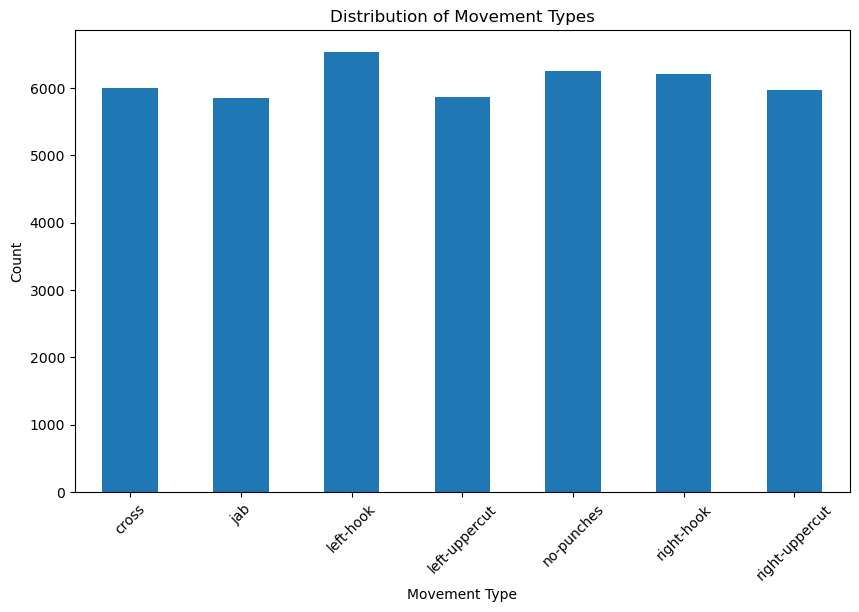

In [5]:
movement_counts = pd.Series(dtype=int)

for file_name, df in dfs.items():
    file_movement_counts = df['movement_type'].value_counts()
    movement_counts = movement_counts.add(file_movement_counts, fill_value=0)
    
plt.figure(figsize=(10, 6))
movement_counts.plot(kind='bar')
plt.title('Distribution of Movement Types')
plt.xlabel('Movement Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Prepare Features and Target

In [6]:
def prepare_data(dataframes):
    X_all = []
    y_all = []
    for df in dataframes.values():
        feature_columns = [col for col in df.columns if col.endswith(('_x', '_y', '_z', '_angle'))]
        X = df[feature_columns]
        y = df['movement_type']
        X_all.append(X)
        y_all.append(y)
    
    X_combined = pd.concat(X_all, axis=0)
    y_combined = pd.concat(y_all, axis=0)
    
    # split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_combined, y_combined, test_size=0.2, random_state=42)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test, scaler

## Model Training And Evaluation

In [7]:
def train_and_evaluate_models(X_train, X_test, y_train, y_test):
    models ={
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'Gradient Boosting':GradientBoostingClassifier(n_estimators=100, random_state=42),
        'SVM': SVC(kernel='rbf', random_state=42),
        'KNN': KNeighborsClassifier(n_neighbors=5)
    }
    
    results = {}
    
    for name, model in models.items():
        
        # train the model
        print(f"Training with {name} algorithm...")
        model.fit(X_train, y_train)
        
        #make predictions
        y_pred = model.predict(X_test)
        
        # calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)
        
        # cross validate
        cv_scores = cross_val_score(model, X_train, y_train, cv = 5)
        
        results[name] = {
            'model': model,
            'accuracy': accuracy,
            'cv_scores': cv_scores,
            'classification_report': classification_report(y_test, y_pred)
        }
        
        print(f"\nResults for {name}:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Cross Validation scores: {cv_scores}")
        print(f"Average CV score: {cv_scores.mean():.4f}")
        print(f"Classification Report:")
        print(results[name]['classification_report'])
        
    return results

## Feature Importance

In [8]:
def plot_feature_importance(model, feature_names, top_n=20):
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x='importance', y='feature', data = feature_importance.head(top_n))
    plt.title(f'Top {top_n} Most Important Features')
    plt.show

## Main Model Script

Training with Random Forest algorithm...

Results for Random Forest:
Accuracy: 0.9936
Cross Validation scores: [0.98740665 0.9847686  0.98799063 0.98667252 0.98403632]
Average CV score: 0.9862
Classification Report:
                precision    recall  f1-score   support

         cross       1.00      1.00      1.00      1242
           jab       0.99      1.00      1.00      1172
     left-hook       1.00      0.99      0.99      1270
 left-uppercut       0.99      1.00      1.00      1189
    no-punches       0.99      0.98      0.99      1226
    right-hook       1.00      0.99      1.00      1255
right-uppercut       0.98      0.99      0.99      1182

      accuracy                           0.99      8536
     macro avg       0.99      0.99      0.99      8536
  weighted avg       0.99      0.99      0.99      8536

Training with Gradient Boosting algorithm...

Results for Gradient Boosting:
Accuracy: 0.9249
Cross Validation scores: [0.92766144 0.92428237 0.92633275 0.92633275 0

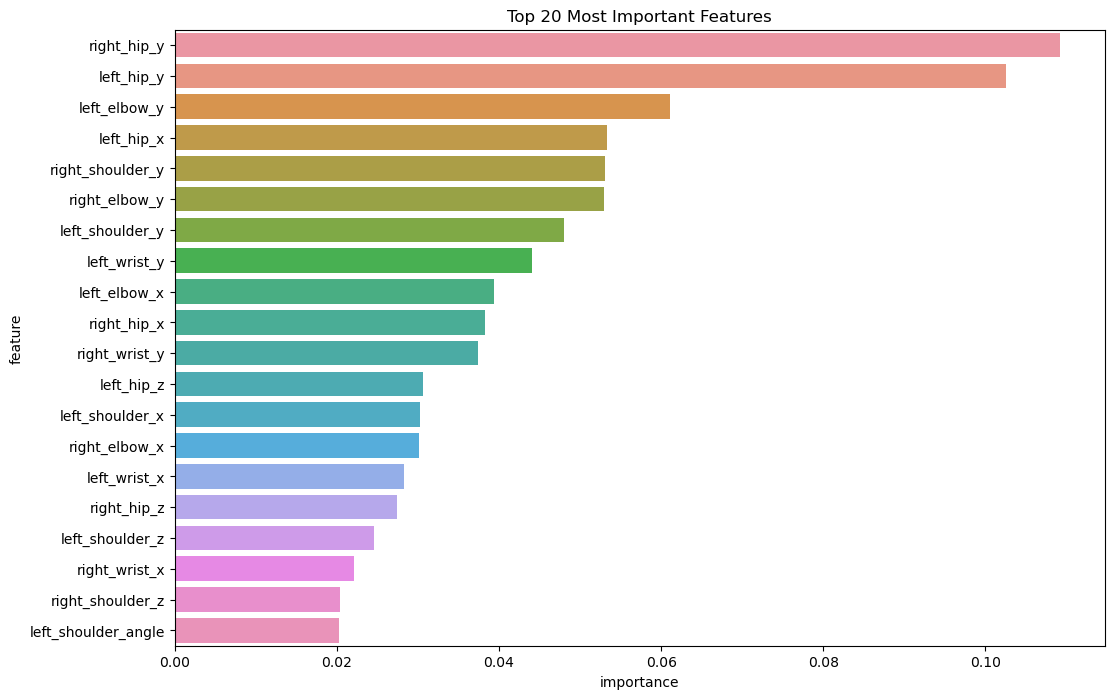

In [9]:
import joblib

# Prepare Data
X_train_scaled, X_test_scaled, y_train, y_test, scaler = prepare_data(dfs)

# Train and Evaluate the Models
results = train_and_evaluate_models(X_train_scaled, X_test_scaled, y_train, y_test)

# Select the best model
best_model_name = max(results, key=lambda x: results[x]['accuracy'])
best_model = results[best_model_name]['model']

print(f"\nBest model: {best_model_name}")

# Plot feature importance for the best model, if it is tree based
if hasattr(best_model, 'feature_importances_'):
    feature_names = [col for col in dfs[list(dfs.keys())[0]].columns if col.endswith(('_x', '_y', '_z', '_angle'))]
    plot_feature_importance(best_model, feature_names)
    

#Save the best model
save_dir = "../models/"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
model_filename = os.path.join(save_dir, 'best_punch_prediction_model.joblib')
scaler_filename = os.path.join(save_dir, 'feature_scaler.joblib')

joblib.dump(best_model, model_filename)
joblib.dump(scaler, scaler_filename)

print(f"Best model saved as {model_filename}")
print(f"Feature scaler saved as {scaler_filename}")